# 拒绝推断
> 使用tensorflow 建立回归模型， 并使用拒绝推断方法对无标签数据打分
## 分配法
此方法是依据每一个分数区间的好坏重新分配好坏客户，并将拒绝件分配到每一个分数区间中，以下是具体步骤：

1） 已知好坏样本，建立初步模型；

2） 使用初步模型对所有被拒绝件进行评分，并预测他们的预期违约率；

3） 将已知的好坏样本依评分分数高低进行分组，计算各分组内实际违约率；

4） 将被拒件依照3）步的分数进行分组，以各分组的实际违约率做为抽样比例，随机抽取该分组下的被拒件，并指定其为坏，其余为好；

5） 将这些推论的有标签的数据新增加到原有的数据集中，重新建模。

In [1]:
import pickle as pkl
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import multiprocess
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

D:\Python27\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train = pd.read_pickle('../data/feature-selected/train.pkl')

In [3]:
eval = pd.read_pickle('../data/feature-selected/eval.pkl')

In [4]:
valid = pd.read_pickle('../data/feature-selected/valid.pkl')
valid['label']=0
valid['tag']=0
valid.head()

,loan_dt,f1,f2,f5,f14,f15,f18,f20,f21,f28,...,f6725,f6728,f6734,f6735,f6737,f6742,f6743,f6745,label,tag
id,,,,,,,,,,,,,,,,,,,,,
100001,2018-03-07,57.0,0.0,442.180084,NaN,5.0000,0,0.024681,1.0,0.033447,...,27.620493,0.200,450.100006,0.000851,20293.0,0,0.0,49.197765,0,0
100002,2018-03-07,0.0,NaN,0.000000,0.000039,5.3333,0,0.000000,NaN,0.000000,...,14.480687,0.000,NaN,0.000000,6638.0,0,0.0,0.000000,0,0
100003,2018-01-27,0.0,NaN,21.197485,NaN,3.5000,0,0.013158,NaN,0.327245,...,11.838667,0.000,3893.979980,0.002193,32251.0,0,0.0,27.341463,0,0
100004,2018-03-29,0.0,NaN,0.000000,NaN,5.2727,0,0.006873,NaN,0.000000,...,24.462925,0.000,NaN,0.004009,36614.0,0,0.0,0.000000,0,0
100005,2018-01-23,0.0,41.0,43.675888,0.000208,23.0000,0,0.096890,99.0,0.007577,...,8.279123,0.125,NaN,0.000000,16384.0,0,0.0,15.253415,0,0


### DeepFM

In [5]:
#======config=========

SUB_DIR = "./"


NUM_SPLITS = 3
RANDOM_SEED = 233

# types of columns of the dataset dataframe
fdump = './categorical_features.pkl'
CATEGORICAL_COLS = pkl.load(open(fdump,'rb'))

NUMERIC_COLS = np.setdiff1d(list(train.columns),CATEGORICAL_COLS+['loan_dt','tag','label'])
IGNORE_COLS = ['loan_dt','tag','label']

In [6]:
from __future__ import unicode_literals
import pandas as pd
import numpy as np
import json
import sys
from sklearn.model_selection import train_test_split
import xgboost as xgb
import sklearn
import os
%matplotlib inline
from sklearn.utils import shuffle
import time

import numpy as np
import pandas as pd
from sklearn.model_selection import *


def gini(actual, pred):
    assert (len(actual) == len(pred))
    #np.c_是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等，类似于pandas中的merge()。
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    #np.arange创建等差数组，其实是生成index:0~n-1
    #pred 列取负数：-1 * all[:, 1]
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]  #把pred列的分数由高到低排序
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_norm(actual, pred):
    return gini(actual, pred) / gini(actual, actual)


def custom_error(preds, dtrain):
    labels = dtrain.get_label()
    

    return 'gini_norm',gini_norm(labels,preds)


In [ ]:
#==========data_reader========
import time
#-------------------------------------------------
# 计时装饰器
#-------------------------------------------------
def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print('func:%r took: %2.4f sec' % \
          (f.__name__, te-ts)
        )
        return result

    return timed

class FeatureDictionary(object):
    def __init__(self, trainfile=None, testfile=None,
                 dfTrain=None, dfTest=None, numeric_cols=[], ignore_cols=[]):
        assert not ((trainfile is None) and (dfTrain is None)), "trainfile or dfTrain at least one is set"
        assert not ((trainfile is not None) and (dfTrain is not None)), "only one can be set"
        assert not ((testfile is None) and (dfTest is None)), "testfile or dfTest at least one is set"
        assert not ((testfile is not None) and (dfTest is not None)), "only one can be set"
        self.trainfile = trainfile
        self.testfile = testfile
        self.dfTrain = dfTrain
        self.dfTest = dfTest
        self.numeric_cols = numeric_cols
        self.ignore_cols = ignore_cols
        self.gen_feat_dict()

    @timeit
    def gen_feat_dict(self):
        if self.dfTrain is None:
            dfTrain = pd.read_csv(self.trainfile)
        else:
            dfTrain = self.dfTrain
        if self.dfTest is None:
            dfTest = pd.read_csv(self.testfile)
        else:
            dfTest = self.dfTest
        
        df = pd.concat([dfTrain, dfTest]) #首尾相连
        self.feat_dict = {}
        tc = 0
        for col in df.columns:
            if col in self.ignore_cols:
                continue
            if col in self.numeric_cols:
                # map to a single index
                self.feat_dict[col] = tc
                tc += 1
            else:
                us = df[col].unique()
                self.feat_dict[col] = dict(zip(us, range(tc, len(us)+tc)))
                tc += len(us)
        self.feat_dim = tc


class DataParser(object):
    def __init__(self, feat_dict):
        self.feat_dict = feat_dict

    @timeit
    def parse(self, infile=None, df=None, has_label=False):
        assert not ((infile is None) and (df is None)), "infile or df at least one is set"
        assert not ((infile is not None) and (df is not None)), "only one can be set"
        if infile is None:
            dfv = df.copy()
        else:
            dfv = pd.read_csv(infile)
        if has_label:
            y = dfv["label"].values.tolist()
        else:
            ids = dfv.index.tolist()
            
        # dfi for feature index
        # dfv for feature value which can be either binary (1/0) or float (e.g., 10.24)
        fd = self.feat_dict
        dfi = pd.DataFrame(np.tile(list(fd.feat_dict.values())[:len(fd.numeric_cols)],(df.shape[0],1)), columns=NUMERIC_COLS)
        
        for col in dfv.columns:
            if col in self.feat_dict.ignore_cols:
                dfv.drop(col, axis=1, inplace=True)
                continue
            
            if col in self.feat_dict.numeric_cols:
                pass
            else:
                dfi[col] = dfv[col].map(self.feat_dict.feat_dict[col])
                dfv[col] = 1.

        # list of list of feature indices of each sample in the dataset
        Xi = dfi.values.tolist()
        # list of list of feature values of each sample in the dataset
        Xv = dfv.values.tolist()
        if has_label:
            return Xi, Xv, y
        else:
            return Xi, Xv, ids


In [11]:
len(NUMERIC_COLS)

2904

In [12]:
# 对数值型特征，normalize处理
from sklearn.preprocessing  import MinMaxScaler
from sklearn.preprocessing.imputation import Imputer

train = train.fillna(0)
tdata = train.drop(['label', 'tag', 'loan_dt'],axis=1)
scaler = MinMaxScaler()
scaler.fit(tdata)

def read_data(data):
    dfX = data.copy()
    dfX = dfX.fillna(0)
    if 'label' in dfX.columns:
        y = dfX.label
        dfX = dfX.drop('label', axis=1)
    else:
        y = None
    X= scaler.transform(dfX)
    return data,X,y



In [13]:
from matplotlib import pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf

gini_scorer = make_scorer(gini_norm, greater_is_better=True, needs_proba=True)
from sklearn.model_selection import train_test_split

def _load_data(train, eval):
    train_data = pd.concat([ train[NUMERIC_COLS],train[CATEGORICAL_COLS+['label']]], axis=1)
    test_data = pd.concat([ eval[NUMERIC_COLS],eval[CATEGORICAL_COLS]], axis=1)
    dfTrain,X_train,y_train = read_data(train_data)
    dfTest,X_test,_ = read_data(test_data)
    ids_test = dfTest.index.tolist()
    cat_features_indices = [i for i,c in enumerate(dfTrain.columns) if c in CATEGORICAL_COLS]

    return dfTrain, dfTest, X_train, y_train, X_test, ids_test, cat_features_indices


def _run_base_model_dfm(dfTrain, dfTest, folds, dfm_params):
    fd = FeatureDictionary(dfTrain=dfTrain, dfTest=dfTest,
                           numeric_cols=NUMERIC_COLS,
                           ignore_cols=IGNORE_COLS)
    data_parser = DataParser(feat_dict=fd)
    Xi_train, Xv_train, y_train = data_parser.parse(df=dfTrain, has_label=True)
    Xi_test, Xv_test, ids_test = data_parser.parse(df=dfTest)

    dfm_params["feature_size"] = fd.feat_dim
    dfm_params["field_size"] = len(Xi_train[0])

    y_train_meta = np.zeros((dfTrain.shape[0], 1), dtype=float)
    y_test_meta = np.zeros((dfTest.shape[0], 1), dtype=float)
    _get = lambda x, l: [x[i] for i in l]
    gini_results_cv = np.zeros(len(folds), dtype=float)
    gini_results_epoch_train = np.zeros((len(folds), dfm_params["epoch"]), dtype=float)
    gini_results_epoch_valid = np.zeros((len(folds), dfm_params["epoch"]), dtype=float)

    for i, (train_idx, valid_idx) in enumerate(folds):
        #valid_idx = valid_idx[:1024]
        Xi_train_, Xv_train_, y_train_ = _get(Xi_train, train_idx), _get(Xv_train, train_idx), _get(y_train, train_idx)
        Xi_valid_, Xv_valid_, y_valid_ = _get(Xi_train, valid_idx), _get(Xv_train, valid_idx), _get(y_train, valid_idx)

        dfm = DeepFM(**dfm_params)
        dfm.fit(Xi_train_, Xv_train_, y_train_, Xi_valid_, Xv_valid_, y_valid_)
        #dfm.fit(Xi_train_, Xv_train_, y_train_, Xi_valid_, Xv_valid_, y_valid_,early_stopping=True)
        y_train_meta[valid_idx,0]= dfm.predict(Xi_valid_, Xv_valid_)
        y_test_meta[:,0] += dfm.predict(Xi_test, Xv_test)

        gini_results_cv[i] = gini_norm(y_valid_, y_train_meta[valid_idx])
        gini_results_epoch_train[i] = dfm.train_result
        gini_results_epoch_valid[i] = dfm.valid_result

    y_test_meta /= float(len(folds))

    # save result
    if dfm_params["use_fm"] and dfm_params["use_deep"]:
        clf_str = "DeepFM"
    elif dfm_params["use_fm"]:
        clf_str = "FM"
    elif dfm_params["use_deep"]:
        clf_str = "DNN"
    print("%s: %.5f (%.5f)"%(clf_str, gini_results_cv.mean(), gini_results_cv.std()))
    filename = "%s_Mean%.5f_Std%.5f.csv"%(clf_str, gini_results_cv.mean(), gini_results_cv.std())
    _save_result(ids_test, y_test_meta, filename)

    _plot_fig(gini_results_epoch_train, gini_results_epoch_valid, clf_str)

    return y_train_meta, y_test_meta

def _save_result(ids, y_pred, filename="dfm_res.csv"):
    pd.DataFrame({"id": ids, "target": y_pred.flatten()}).to_csv(
    os.path.join(SUB_DIR, filename), index=False, float_format="%.5f")



def _plot_fig(train_results, valid_results, model_name):
    colors = ["red", "blue", "green"]
    xs = np.arange(1, train_results.shape[1]+1)
    plt.figure()
    legends = []
    for i in range(train_results.shape[0]):
        plt.plot(xs, train_results[i], color=colors[i], linestyle="solid", marker="o")
        plt.plot(xs, valid_results[i], color=colors[i], linestyle="dashed", marker="o")
        legends.append("train-%d"%(i+1))
        legends.append("valid-%d"%(i+1))
    plt.xlabel("Epoch")
    plt.ylabel("Normalized Gini")
    plt.title("%s"%model_name)
    plt.legend(legends)
    plt.savefig("./fig/%s.png"%model_name)
    plt.close()





Train Model

In [15]:
def accuracy(actual, pred):
    dfm_res= []
    for i in pred:
        if i >0.5:
            dfm_res.append(1)
        else:
            dfm_res.append(0)
    print("pred: %d , actual: %d , total : %d" % (sum(dfm_res),sum(actual),len(pred)))
    
    s = sklearn.metrics.accuracy_score(actual,dfm_res)
    return s
def gini_norm(actual, pred):
    dfm_res= []
    for i in pred:
        if i >0.5:
            dfm_res.append(1)
        else:
            dfm_res.append(0)
    print("pred: %d , actual: %d , total : %d" % (sum(dfm_res),sum(actual),len(pred)))
    return gini(actual, pred) / gini(actual, actual)


In [16]:
# %load DeepFM

"""
Tensorflow implementation of DeepFM [1]
Reference:
[1] DeepFM: A Factorization-Machine based Neural Network for CTR Prediction,
    Huifeng Guo, Ruiming Tang, Yunming Yey, Zhenguo Li, Xiuqiang He.
"""

import numpy as np
import tensorflow as tf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score
import time
from tensorflow.contrib.layers.python.layers import batch_norm as batch_norm
from yellowfin import YFOptimizer


class DeepFM(BaseEstimator, TransformerMixin):
    def __init__(self, feature_size, field_size,
                 embedding_size=8, dropout_fm=[1.0, 1.0],
                 deep_layers=[32, 32], dropout_deep=[0.5, 0.5, 0.5],
                 deep_layers_activation=tf.nn.relu,
                 epoch=10, batch_size=256,
                 learning_rate=0.001, optimizer_type="adam",
                 batch_norm=0, batch_norm_decay=0.995,
                 verbose=False, random_seed=2016,
                 use_fm=True, use_deep=True,
                 loss_type="logloss", eval_metric=roc_auc_score,
                 l2_reg=0.0, greater_is_better=True):
        assert (use_fm or use_deep)
        assert loss_type in ["logloss", "mse"], \
            "loss_type can be either 'logloss' for classification task or 'mse' for regression task"

        self.feature_size = feature_size        # denote as M, size of the feature dictionary
        self.field_size = field_size            # denote as F, size of the feature fields
        self.embedding_size = embedding_size    # denote as K, size of the feature embedding

        self.dropout_fm = dropout_fm
        self.deep_layers = deep_layers
        self.dropout_deep = dropout_deep
        self.deep_layers_activation = deep_layers_activation
        self.use_fm = use_fm
        self.use_deep = use_deep
        self.l2_reg = l2_reg

        self.epoch = epoch
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer_type = optimizer_type

        self.batch_norm = batch_norm
        self.batch_norm_decay = batch_norm_decay

        self.verbose = verbose
        self.random_seed = random_seed
        self.loss_type = loss_type
        self.eval_metric = eval_metric
        self.greater_is_better = greater_is_better
        self.train_result, self.valid_result = [], []

        self._init_graph()


    def _init_graph(self):
        self.graph = tf.Graph()
        with self.graph.as_default():

            tf.set_random_seed(self.random_seed)

            self.feat_index = tf.placeholder(tf.int32, shape=[None, None],
                                                 name="feat_index")  # None * F
            self.feat_value = tf.placeholder(tf.float32, shape=[None, None],
                                                 name="feat_value")  # None * F
            self.label = tf.placeholder(tf.float32, shape=[None, 1], name="label")  # None * 1
            self.dropout_keep_fm = tf.placeholder(tf.float32, shape=[None], name="dropout_keep_fm")
            self.dropout_keep_deep = tf.placeholder(tf.float32, shape=[None], name="dropout_keep_deep")
            self.train_phase = tf.placeholder(tf.bool, name="train_phase")

            self.weights = self._initialize_weights()

            # model
            self.embeddings = tf.nn.embedding_lookup(self.weights["feature_embeddings"],
                                                             self.feat_index)  # None * F * K
            feat_value = tf.reshape(self.feat_value, shape=[-1, self.field_size, 1])
            self.embeddings = tf.multiply(self.embeddings, feat_value)

            # ---------- first order term ----------
            self.y_first_order = tf.nn.embedding_lookup(self.weights["feature_bias"], self.feat_index) # None * F * 1
            self.y_first_order = tf.reduce_sum(tf.multiply(self.y_first_order, feat_value), 2)  # None * F
            self.y_first_order = tf.nn.dropout(self.y_first_order, self.dropout_keep_fm[0]) # None * F

            # ---------- second order term ---------------
            # sum_square part
            self.summed_features_emb = tf.reduce_sum(self.embeddings, 1)  # None * K
            self.summed_features_emb_square = tf.square(self.summed_features_emb)  # None * K

            # square_sum part
            self.squared_features_emb = tf.square(self.embeddings)
            self.squared_sum_features_emb = tf.reduce_sum(self.squared_features_emb, 1)  # None * K

            # second order
            self.y_second_order = 0.5 * tf.subtract(self.summed_features_emb_square, self.squared_sum_features_emb)  # None * K
            self.y_second_order = tf.nn.dropout(self.y_second_order, self.dropout_keep_fm[1])  # None * K

            # ---------- Deep component ----------
            self.y_deep = tf.reshape(self.embeddings, shape=[-1, self.field_size * self.embedding_size]) # None * (F*K)
            self.y_deep = tf.nn.dropout(self.y_deep, self.dropout_keep_deep[0])
            for i in range(0, len(self.deep_layers)):
                self.y_deep = tf.add(tf.matmul(self.y_deep, self.weights["layer_%d" %i]), self.weights["bias_%d"%i]) # None * layer[i] * 1
                if self.batch_norm:
                    self.y_deep = self.batch_norm_layer(self.y_deep, train_phase=self.train_phase, scope_bn="bn_%d" %i) # None * layer[i] * 1
                self.y_deep = self.deep_layers_activation(self.y_deep)
                self.y_deep = tf.nn.dropout(self.y_deep, self.dropout_keep_deep[1+i]) # dropout at each Deep layer

            # ---------- DeepFM ----------
            if self.use_fm and self.use_deep:
                concat_input = tf.concat([self.y_first_order, self.y_second_order, self.y_deep], axis=1)
            elif self.use_fm:
                concat_input = tf.concat([self.y_first_order, self.y_second_order], axis=1)
            elif self.use_deep:
                concat_input = self.y_deep
            self.out = tf.add(tf.matmul(concat_input, self.weights["concat_projection"]), self.weights["concat_bias"])

            # loss
            if self.loss_type == "logloss":
                self.out = tf.nn.sigmoid(self.out)
                self.loss = tf.losses.log_loss(self.label, self.out)
            elif self.loss_type == "mse":
                self.loss = tf.nn.l2_loss(tf.subtract(self.label, self.out))
            # l2 regularization on weights
            if self.l2_reg > 0:
                self.loss += tf.contrib.layers.l2_regularizer(
                    self.l2_reg)(self.weights["concat_projection"])
                if self.use_deep:
                    for i in range(len(self.deep_layers)):
                        self.loss += tf.contrib.layers.l2_regularizer(
                            self.l2_reg)(self.weights["layer_%d"%i])

            # optimizer
            if self.optimizer_type == "adam":
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, beta2=0.999,
                                                        epsilon=1e-8).minimize(self.loss)
            elif self.optimizer_type == "adagrad":
                self.optimizer = tf.train.AdagradOptimizer(learning_rate=self.learning_rate,
                                                           initial_accumulator_value=1e-8).minimize(self.loss)
            elif self.optimizer_type == "gd":
                self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
            elif self.optimizer_type == "momentum":
                self.optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=0.95).minimize(
                    self.loss)
            elif self.optimizer_type == "yellowfin":
                self.optimizer = YFOptimizer(learning_rate=self.learning_rate, momentum=0.0).minimize(
                    self.loss)

            # init
            self.saver = tf.train.Saver()
            init = tf.global_variables_initializer()
            self.sess = self._init_session()
            self.sess.run(init)

            # number of params
            total_parameters = 0
            for variable in self.weights.values():
                shape = variable.get_shape()
                variable_parameters = 1
                for dim in shape:
                    variable_parameters *= dim.value
                total_parameters += variable_parameters
            if self.verbose > 0:
                print("#params: %d" % total_parameters)


    def _init_session(self):
        config = tf.ConfigProto(device_count={"gpu": 0})
        config.gpu_options.allow_growth = True
        return tf.Session(config=config)


    def _initialize_weights(self):
        weights = dict()

        # embeddings
        weights["feature_embeddings"] = tf.Variable(
            tf.random_normal([self.feature_size, self.embedding_size], 0.0, 0.01),
            name="feature_embeddings")  # feature_size * K
        weights["feature_bias"] = tf.Variable(
            tf.random_uniform([self.feature_size, 1], 0.0, 1.0), name="feature_bias")  # feature_size * 1

        # deep layers
        num_layer = len(self.deep_layers)
        input_size = self.field_size * self.embedding_size
        glorot = np.sqrt(2.0 / (input_size + self.deep_layers[0]))
        weights["layer_0"] = tf.Variable(
            np.random.normal(loc=0, scale=glorot, size=(input_size, self.deep_layers[0])), dtype=np.float32)
        weights["bias_0"] = tf.Variable(np.random.normal(loc=0, scale=glorot, size=(1, self.deep_layers[0])),
                                                        dtype=np.float32)  # 1 * layers[0]
        for i in range(1, num_layer):
            glorot = np.sqrt(2.0 / (self.deep_layers[i-1] + self.deep_layers[i]))
            weights["layer_%d" % i] = tf.Variable(
                np.random.normal(loc=0, scale=glorot, size=(self.deep_layers[i-1], self.deep_layers[i])),
                dtype=np.float32)  # layers[i-1] * layers[i]
            weights["bias_%d" % i] = tf.Variable(
                np.random.normal(loc=0, scale=glorot, size=(1, self.deep_layers[i])),
                dtype=np.float32)  # 1 * layer[i]

        # final concat projection layer
        if self.use_fm and self.use_deep:
            input_size = self.field_size + self.embedding_size + self.deep_layers[-1]
        elif self.use_fm:
            input_size = self.field_size + self.embedding_size
        elif self.use_deep:
            input_size = self.deep_layers[-1]
        glorot = np.sqrt(2.0 / (input_size + 1))
        weights["concat_projection"] = tf.Variable(
                        np.random.normal(loc=0, scale=glorot, size=(input_size, 1)),
                        dtype=np.float32)  # layers[i-1]*layers[i]
        weights["concat_bias"] = tf.Variable(tf.constant(0.01), dtype=np.float32)

        return weights


    def batch_norm_layer(self, x, train_phase, scope_bn):
        bn_train = batch_norm(x, decay=self.batch_norm_decay, center=True, scale=True, updates_collections=None,
                              is_training=True, reuse=None, trainable=True, scope=scope_bn)
        bn_inference = batch_norm(x, decay=self.batch_norm_decay, center=True, scale=True, updates_collections=None,
                                  is_training=False, reuse=True, trainable=True, scope=scope_bn)
        z = tf.cond(train_phase, lambda: bn_train, lambda: bn_inference)
        return z


    def get_batch(self, Xi, Xv, y, batch_size, index):
        start = index * batch_size
        end = (index+1) * batch_size
        end = end if end < len(y) else len(y)
        return Xi[start:end], Xv[start:end], [[y_] for y_ in y[start:end]]


    # shuffle three lists simutaneously
    def shuffle_in_unison_scary(self, a, b, c):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)


    def fit_on_batch(self, Xi, Xv, y):
        feed_dict = {self.feat_index: Xi,
                     self.feat_value: Xv,
                     self.label: y,
                     self.dropout_keep_fm: self.dropout_fm,
                     self.dropout_keep_deep: self.dropout_deep,
                     self.train_phase: True}
        import pdb; pdb.set_trace()
        loss, opt = self.sess.run((self.loss, self.optimizer), feed_dict=feed_dict)
        return loss


    def fit(self, Xi_train, Xv_train, y_train,
            Xi_valid=None, Xv_valid=None, y_valid=None,
            early_stopping=False, refit=False):
        """
        :param Xi_train: [[ind1_1, ind1_2, ...], [ind2_1, ind2_2, ...], ..., [indi_1, indi_2, ..., indi_j, ...], ...]
                         indi_j is the feature index of feature field j of sample i in the training set
        :param Xv_train: [[val1_1, val1_2, ...], [val2_1, val2_2, ...], ..., [vali_1, vali_2, ..., vali_j, ...], ...]
                         vali_j is the feature value of feature field j of sample i in the training set
                         vali_j can be either binary (1/0, for binary/categorical features) or float (e.g., 10.24, for numerical features)
        :param y_train: label of each sample in the training set
        :param Xi_valid: list of list of feature indices of each sample in the validation set
        :param Xv_valid: list of list of feature values of each sample in the validation set
        :param y_valid: label of each sample in the validation set
        :param early_stopping: perform early stopping or not
        :param refit: refit the model on the train+valid dataset or not
        :return: None
        """
        has_valid = Xv_valid is not None
        for epoch in range(self.epoch):
            t1 = time.clock()
            self.shuffle_in_unison_scary(Xi_train, Xv_train, y_train)
            total_batch = int(len(y_train) / self.batch_size)
            for i in range(total_batch):
                Xi_batch, Xv_batch, y_batch = self.get_batch(Xi_train, Xv_train, y_train, self.batch_size, i)
                self.fit_on_batch(Xi_batch, Xv_batch, y_batch)

            # evaluate training and validation datasets
            train_result = self.evaluate(Xi_train, Xv_train, y_train)
            self.train_result.append(train_result)
            if has_valid:
                valid_result = self.evaluate(Xi_valid, Xv_valid, y_valid)
                self.valid_result.append(valid_result)
            if self.verbose > 0 and epoch % self.verbose == 0:
                if has_valid:
                    print("[%d] train-result=%.4f, valid-result=%.4f [%.1f s]"
                        % (epoch + 1, train_result, valid_result, time.clock() - t1))
                else:
                    print("[%d] train-result=%.4f [%.1f s]"
                        % (epoch + 1, train_result, time.clock() - t1))
            if has_valid and early_stopping and self.training_termination(self.valid_result):
                break

        # fit a few more epoch on train+valid until result reaches the best_train_score
        if has_valid and refit:
            if self.greater_is_better:
                best_valid_score = max(self.valid_result)
            else:
                best_valid_score = min(self.valid_result)
            best_epoch = self.valid_result.index(best_valid_score)
            best_train_score = self.train_result[best_epoch]
            Xi_train = Xi_train + Xi_valid
            Xv_train = Xv_train + Xv_valid
            y_train = y_train + y_valid
            for epoch in range(100):
                self.shuffle_in_unison_scary(Xi_train, Xv_train, y_train)
                total_batch = int(len(y_train) / self.batch_size)
                for i in range(total_batch):
                    Xi_batch, Xv_batch, y_batch = self.get_batch(Xi_train, Xv_train, y_train,
                                                                self.batch_size, i)
                    self.fit_on_batch(Xi_batch, Xv_batch, y_batch)
                # check
                train_result = self.evaluate(Xi_train, Xv_train, y_train)
                if abs(train_result - best_train_score) < 0.001 or \
                    (self.greater_is_better and train_result > best_train_score) or \
                    ((not self.greater_is_better) and train_result < best_train_score):
                    break


    def training_termination(self, valid_result):
        if len(valid_result) > 5:
            if self.greater_is_better:
                if valid_result[-1] < valid_result[-2] and \
                    valid_result[-2] < valid_result[-3] and \
                    valid_result[-3] < valid_result[-4] and \
                    valid_result[-4] < valid_result[-5]:
                    return True
            else:
                if valid_result[-1] > valid_result[-2] and \
                    valid_result[-2] > valid_result[-3] and \
                    valid_result[-3] > valid_result[-4] and \
                    valid_result[-4] > valid_result[-5]:
                    return True
        return False


    def predict(self, Xi, Xv):
        """
        :param Xi: list of list of feature indices of each sample in the dataset
        :param Xv: list of list of feature values of each sample in the dataset
        :return: predicted probability of each sample
        """
        # dummy y
        dummy_y = [1] * len(Xi)
        batch_index = 0
        Xi_batch, Xv_batch, y_batch = self.get_batch(Xi, Xv, dummy_y, self.batch_size, batch_index)
        y_pred = None
        while len(Xi_batch) > 0:
            num_batch = len(y_batch)
            feed_dict = {self.feat_index: Xi_batch,
                         self.feat_value: Xv_batch,
                         self.label: y_batch,
                         self.dropout_keep_fm: [1.0] * len(self.dropout_fm),
                         self.dropout_keep_deep: [1.0] * len(self.dropout_deep),
                         self.train_phase: False}
            batch_out = self.sess.run(self.out, feed_dict=feed_dict)

            if batch_index == 0:
                y_pred = np.reshape(batch_out, (num_batch,))
            else:
                y_pred = np.concatenate((y_pred, np.reshape(batch_out, (num_batch,))))

            batch_index += 1
            Xi_batch, Xv_batch, y_batch = self.get_batch(Xi, Xv, dummy_y, self.batch_size, batch_index)

        return y_pred


    def evaluate(self, Xi, Xv, y):
        """
        :param Xi: list of list of feature indices of each sample in the dataset
        :param Xv: list of list of feature values of each sample in the dataset
        :param y: label of each sample in the dataset
        :return: metric of the evaluation
        """
        y_pred = self.predict(Xi, Xv)
        return self.eval_metric(y, y_pred)


In [33]:
# load data
dfTrain, dfTest, X_train, y_train, X_test, ids_test, cat_features_indices = _load_data(train.ix[:1000], eval)

# folds
folds = list(StratifiedKFold(n_splits=NUM_SPLITS, shuffle=True,
                             random_state=RANDOM_SEED).split(X_train, y_train))
fd = FeatureDictionary(dfTrain=dfTrain, dfTest=dfTest,
                           numeric_cols=NUMERIC_COLS,
                           ignore_cols=IGNORE_COLS)
# data_parser = DataParser(feat_dict=fd)
# Xi_train, Xv_train, _ = data_parser.parse(df=dfTrain, has_label=False)
# Xi_test, Xv_test, ids_test = data_parser.parse(df=dfTest)


> <ipython-input-29-3cfe2046e1a0>(46)gen_feat_dict()
-> df = pd.concat([dfTrain, dfTest]) #首尾相连
(Pdb) c
func:'gen_feat_dict' took: 5.4813 sec


In [38]:
# ------------------ DeepFM Model ------------------

dfm_params = {
    "use_fm": True,
    "use_deep": True,
    "embedding_size": 8,
    "dropout_fm": [1, 1],
    "deep_layers": [32],   
    "dropout_deep": [0.5, 0.5, 0.5],
    "deep_layers_activation": tf.nn.sigmoid,
    "epoch": 10,
    "batch_size": 1024,
    "learning_rate": 0.004,
    "optimizer_type": "adam",
    "batch_norm": 1,
    "batch_norm_decay": 0.997,
    "l2_reg": 0.01,
    "verbose": True,
    "eval_metric": gini_norm,   
    "random_seed": RANDOM_SEED,
#     "use_sample_weights": True,
#     "sample_weights_dict":{0:1,1:2},
    
}
y_train_dfm, y_test_dfm = _run_base_model_dfm(dfTrain, dfTest, folds, dfm_params)


> <ipython-input-29-3cfe2046e1a0>(46)gen_feat_dict()
-> df = pd.concat([dfTrain, dfTest]) #首尾相连
(Pdb) c
func:'gen_feat_dict' took: 3.1272 sec
> <ipython-input-29-3cfe2046e1a0>(85)parse()
-> for col in dfv.columns:
(Pdb) c
func:'parse' took: 2.6632 sec
> <ipython-input-29-3cfe2046e1a0>(85)parse()
-> for col in dfv.columns:
(Pdb) c
func:'parse' took: 158.6941 sec
#params: 787264


TypeError: int() argument must be a string, a bytes-like object or a number, not 'dict'

拒绝推断

In [50]:
X_i, y_i = slice(train_data)
train_preds = model.run(model.y_prob, X_i, mode='test')
train_preds

array([0.07816186, 0.0199602 , 0.00691541, ..., 0.01492001, 0.03813977,
       0.05409675], dtype=float32)

In [51]:
X_i, y_i = slice(test_data)
test_preds = model.run(model.y_prob, X_i, mode='test')
test_preds

array([0.11544644, 0.11100484, 0.10585465, ..., 0.07886463, 0.39337125,
       0.22234131], dtype=float32)

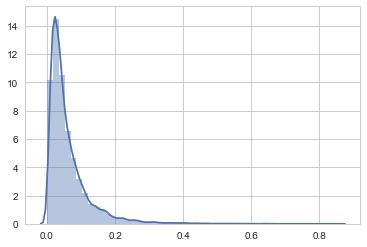

In [52]:
%matplotlib inline
sns.distplot(test_preds, rug=False);

In [53]:
valid_preds = np.array(test_preds)
pred_overdue_rate = np.mean(test_preds>=0.4)
actual_overdue_rate = test_data[1].mean()
print('predicted overdue rate:%f'%pred_overdue_rate)
print('actual overdue rate: %f' % actual_overdue_rate)

predicted overdue rate:0.004527
actual overdue rate: 0.065103


In [54]:
test_data[1].mean()

0.06510322540998459